In [404]:
# !pip install yfinance
# !pip install pmdarima
# !pip install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 42.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 15.3 MB/s eta 0:00:00


## Import dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import datetime
from datetime import datetime
import yfinance as yf
from math import sqrt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import SARIMAX
from pmdarima import auto_arima

from pandas.plotting import autocorrelation_plot

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM

import warnings
warnings.filterwarnings('ignore')

from src.visualization.visualize import Visualizations
from src.features.build_features import Features
from src.models.train_model import Models
from src.models.predict_model import Forecast

/Users/fasmina/opt/anaconda3/envs/ValueInvestor/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-29 11:08:23.816810: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load data

In [2]:
ticker = "AAPL"
start_date = "2019-01-01"
end_date = "2022-12-31"

data = yf.download(ticker, start=start_date, end=end_date)
print(data.head())


[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2019-01-02  38.722500  39.712502  38.557499  39.480000  37.994495  148158800
2019-01-03  35.994999  36.430000  35.500000  35.547501  34.209961  365248800
2019-01-04  36.132500  37.137501  35.950001  37.064999  35.670364  234428400
2019-01-07  37.174999  37.207500  36.474998  36.982498  35.590961  219111200
2019-01-08  37.389999  37.955002  37.130001  37.687500  36.269432  164101200



    Open : the price the stock opened at

    High : the highest price during the day

    Low : the lowest price during the day

    Close : the closing price on the trading day
    
    Adj Close : Closing price that has been adjusted.
    
    Volume : Volume – how many shares were traded


In [3]:
# shape of the data

data.shape

(1008, 6)

In [4]:
# summary statistics

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1008 entries, 2019-01-02 to 2022-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1008 non-null   float64
 1   High       1008 non-null   float64
 2   Low        1008 non-null   float64
 3   Close      1008 non-null   float64
 4   Adj Close  1008 non-null   float64
 5   Volume     1008 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 55.1 KB


In [5]:
# Descriptive statistics

data.describe()

Open         High          Low        Close    Adj Close   
count  1008.000000  1008.000000  1008.000000  1008.000000  1008.000000  \
mean    110.665816   112.034063   109.353214   110.749856   109.322033   
std      43.242655    43.771753    42.664392    43.223091    43.342453   
min      35.994999    36.430000    35.500000    35.547501    34.209961   
25%      66.600000    67.390625    65.835003    66.695627    65.176836   
50%     123.705002   125.080002   122.174999   123.645000   122.018028   
75%     147.014996   148.767502   145.577499   147.044994   146.078957   
max     182.630005   182.940002   179.119995   182.009995   180.434296   

             Volume  
count  1.008000e+03  
mean   1.120997e+08  
std    5.310973e+07  
min    3.519590e+07  
25%    7.755390e+07  
50%    9.693830e+07  
75%    1.290616e+08  
max    4.265100e+08

## Exploratory Data Analysis

<Axes: xlabel='Date'>

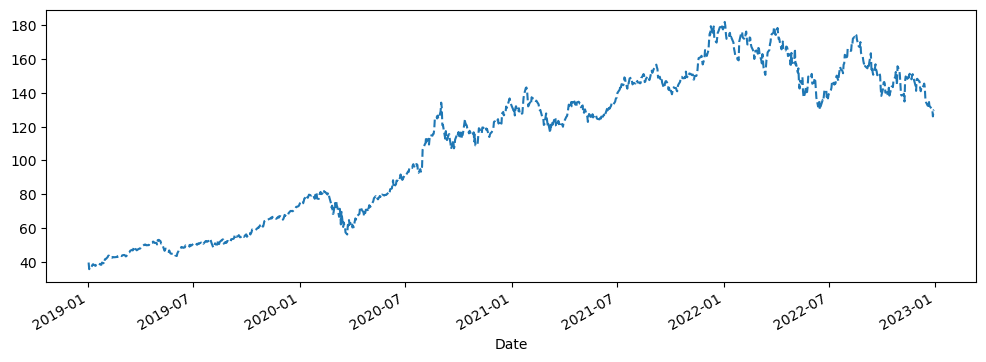

In [6]:
data['Close'].plot(figsize=(12,4), ls='--')

This plot indicates that the Closing price of the stock has been increasing gradually w.r.t time

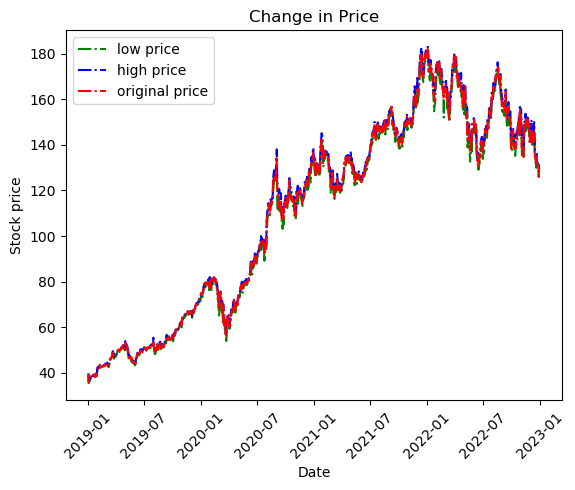

In [7]:
y = ['Low', 'High', 'Close']
labels = ['low price', 'high price', 'original price']
color = ['green','blue','red']
Visualizations.plot_price_diff(data, y = y, labels = labels, colors = color)

Closing price, low price and high price are almost same 

## Seasonal Decompose

For the better understanding of underlying patterns and fluctuations in the data, we can now use seasonal decomposition which will break down the data into 3 components: trend, seasonality and residual.

    * Trend : shows the overall growth or decline in the series, ignoring short-term fluctuations.
    
    * Seasonality : captures the repetitive patterns that occur at fixed intervals, such as daily, weekly or yearly cycles which reflects the regular, predictable fluctuations in the data.
    
    * Residual : represents the leftover variation in the data after removing the trend and seasonality.It consists of the random fluctuations, noise, or irregularities that are not explained by the trend and seasonality.

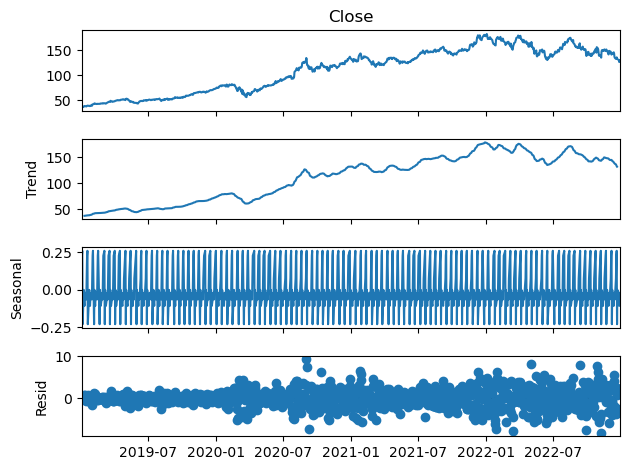

In [8]:
result = seasonal_decompose(data['Close'], model=' multiplicative', period = 10)
result.plot()
plt.show()

Insights from the plot:

    plot 1 : "Closing price" has an increaisng trend.
    
    plot 2 : Apart from the short term fluctuaitons, trend implies an overall growth over time period.
    
    plot 3 : Delivers highly seasonal data.
    
    plot 4 : Numerous random variations are also present

## Stationarity of data

A stationary time series does not show any significant changes in its statistical properties, such as its mean, variance etc as we move through different time periods.

Inorder to apply various statistical model, we need to convert data into stationary if it is not. 

We can check stationarity of data by using several test, here we'll be using Augmented Dickey Fuller test.

The Augmented Dickey-Fuller (ADF) test is a statistical test used to determine the presence of a unit root in a time series dataset. A unit root indicates that the series is non-stationary, meaning it exhibits a trend or some form of dependence on past values. The null hypothesis of the ADF test is that the time series has a unit root and is non-stationary. The alternative hypothesis is that the series is stationary.

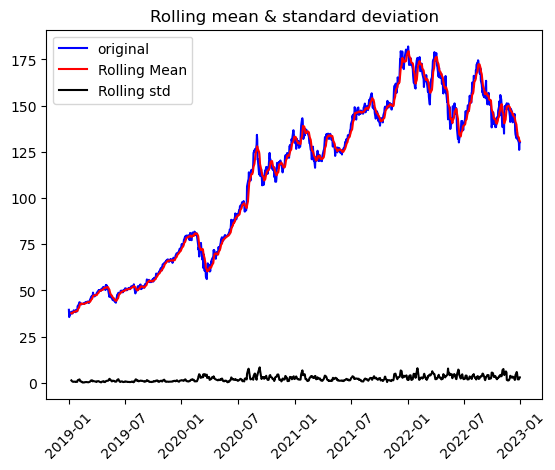

Results of Dickey Fuller Test: 
Test Statistic                   -1.681306
p-value                           0.440769
# laags used                      1.000000
Number of observations used    1006.000000
Critical value (1%)              -3.436867
Critical value (5%)              -2.864417
Critical value (10%)             -2.568302
dtype: float64
week evidence against null hypothesis, time series has a unit root, indicating it is non-stationary


In [9]:
Features.test_stationary(data['Close'])

Since p-value is greater than 0.05, we need to accept null hypothesis as the data is non stationary.

There are several mehtods to make a dataset stationary. Some of the common methods are:

    1. Differencing: Taking the difference between consecutive observations is a common technique to remove trend from the data. This can be done by subtracting the previous observation from the current observation. 
    2. Logarithmic Transformation: Applying a logarithmic transformation to the data can stabilize and reduce the variance, especially if the data exhibits exponential growth or a multiplicative relationship.
    3. Moving Average Method:  It involves calculating the average of a subset of consecutive observations over a specified window and subtracting it from the original data.
   
    
Here I'll be using Moving Average Method

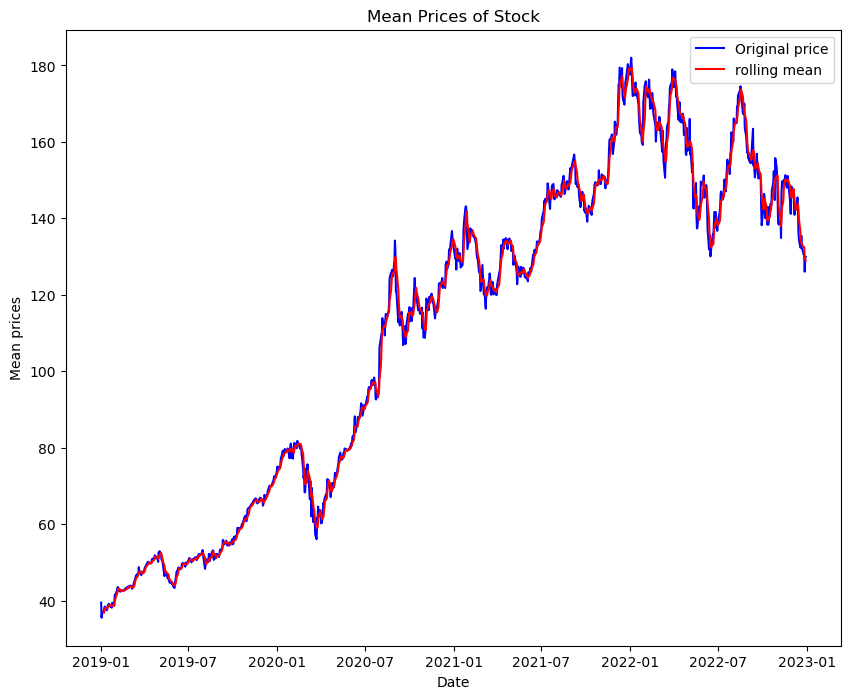

In [10]:
#  Moving Average Method

rolling_mean = data['Close'].rolling(4).mean()
plt.figure(figsize=(10,8))
plt.plot(data['Close'], color = 'blue',label = "Original price")
plt.plot(rolling_mean, color='red', label = "rolling mean")
plt.title("Mean Prices of Stock")
plt.xlabel("Date")
plt.ylabel("Mean prices")
plt.legend()
plt.show()

In [11]:
rolling_mean_diff = data['Close'] - rolling_mean
rolling_mean_diff.dropna(inplace = True)

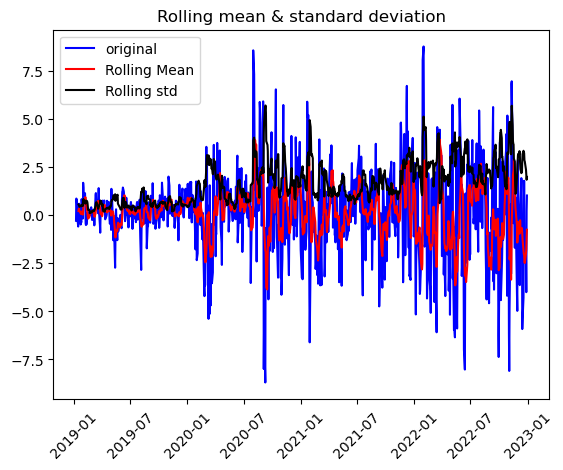

Results of Dickey Fuller Test: 
Test Statistic                -8.690529e+00
p-value                        4.052227e-14
# laags used                   1.000000e+01
Number of observations used    9.940000e+02
Critical value (1%)           -3.436946e+00
Critical value (5%)           -2.864452e+00
Critical value (10%)          -2.568321e+00
dtype: float64
strong evidence against null hypothesis, reject the null hypothesis. Data has no unit and is stationary


In [12]:
Features.test_stationary(rolling_mean_diff)

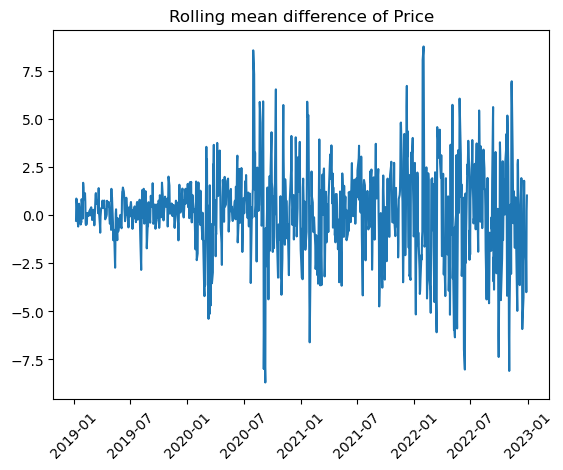

In [13]:
# Line plot of moving average difference of price

plt.plot(rolling_mean_diff)
plt.title("Rolling mean difference of Price", size=12)
plt.xticks(rotation=45)
plt.show()

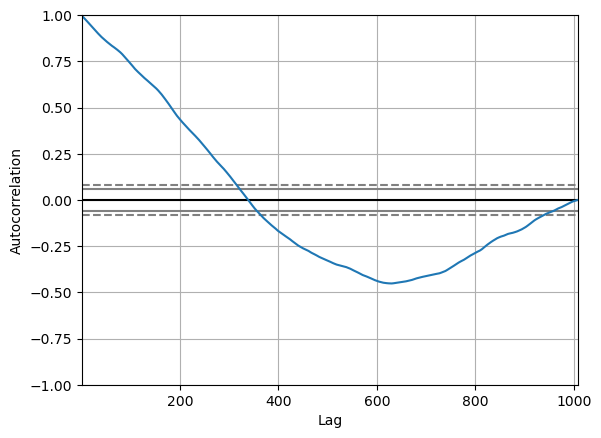

In [14]:
autocorrelation_plot(data['Close'])
plt.show()

## PACF & ACF plot

The Autocorrelation Function (ACF) plot shows how correlated a data point is with its past values at different time lags. It helps identify patterns of correlation in the time series data.

The Partial Autocorrelation Function (PACF) plot measures the direct correlation between a data point and its specific lagged values while accounting for the influence of other lags.

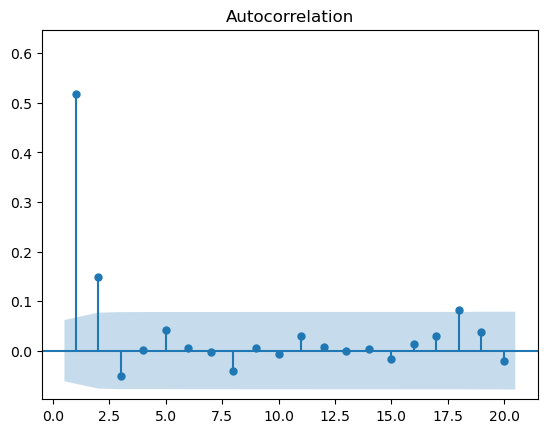

In [15]:
plot_acf(rolling_mean_diff, zero=False, lags=20, auto_ylims=True)
plt.show()

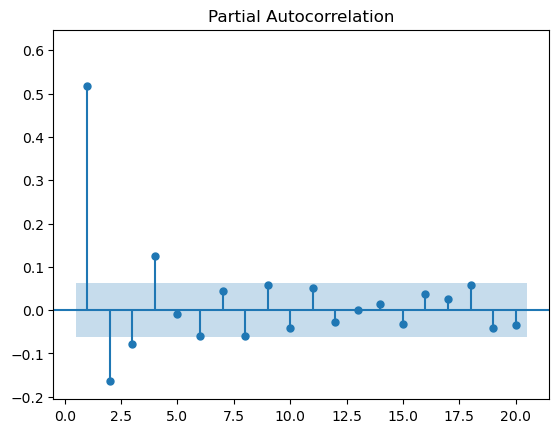

In [16]:
plot_pacf(rolling_mean_diff, zero=False, lags=20, auto_ylims=True)
plt.show()

## Split data into training and testing part

Splitting Data into Training and Testing Sets:

To perform the time series analysis, the dataset needs to be split into training and testing parts. In this case, the training part will consist of data from the years 2019, 2020, and 2021, while the testing part will include the data from the year 2022.

This division ensures that the model is trained on historical data up until the year 2021 and then tested on unseen data from the year 2022. By evaluating the model's performance on the testing set, we can assess its ability to generalize and make accurate predictions on new, unseen data.



In [17]:
train_data = data[(data.index.year == 2019) | (data.index.year == 2020) | (data.index.year == 2021)]

test_data = data[data.index.year == 2022]

print('length of training data: ', len(train_data))
print('length of testing data: ', len(test_data))

length of training data:  757
length of testing data:  251


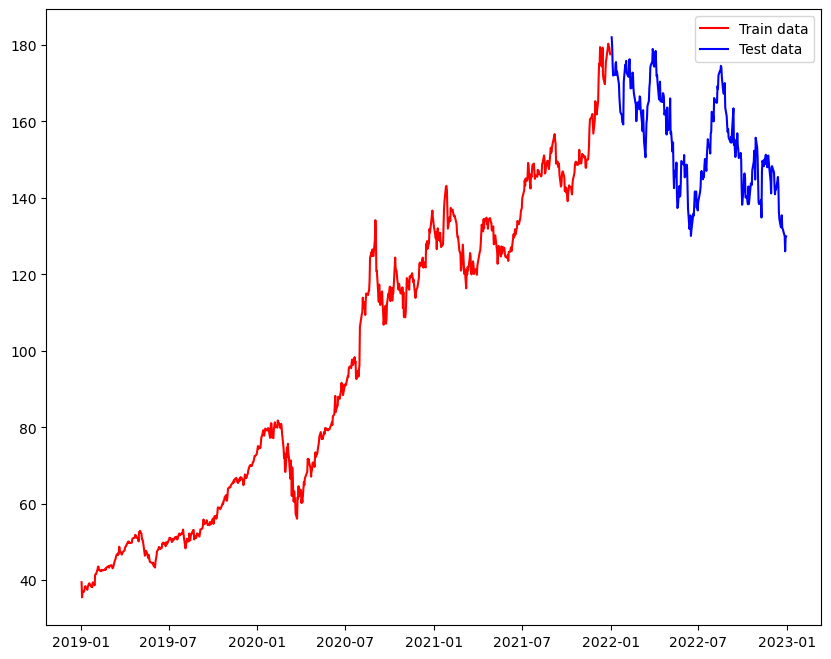

In [18]:
plt.figure(figsize=(10,8))
plt.plot(train_data['Close'], label='Train data', c = 'red')
plt.plot(test_data['Close'], label='Test data', c = 'blue')
plt.legend()

## Auto Arima Model

Auto ARIMA (AutoRegressive Integrated Moving Average) is an automated approach to selecting the optimal parameters for an ARIMA model in time series forecasting. It uses a combination of statistical techniques and information criteria to determine the best set of parameters for the AR, I, and MA components of the model.

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4667.016, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4664.953, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4666.099, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4667.290, Time=0.11 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=4669.272, Time=0.14 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=4668.390, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4665.191, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4665.811, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4667.775, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4669.286, Time=0.24 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4664.290, Time=0.30 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4666.337, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4667.769, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4668.123, Time=0.58 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4667.504, Time=0.35 sec
 ARIMA(3,1

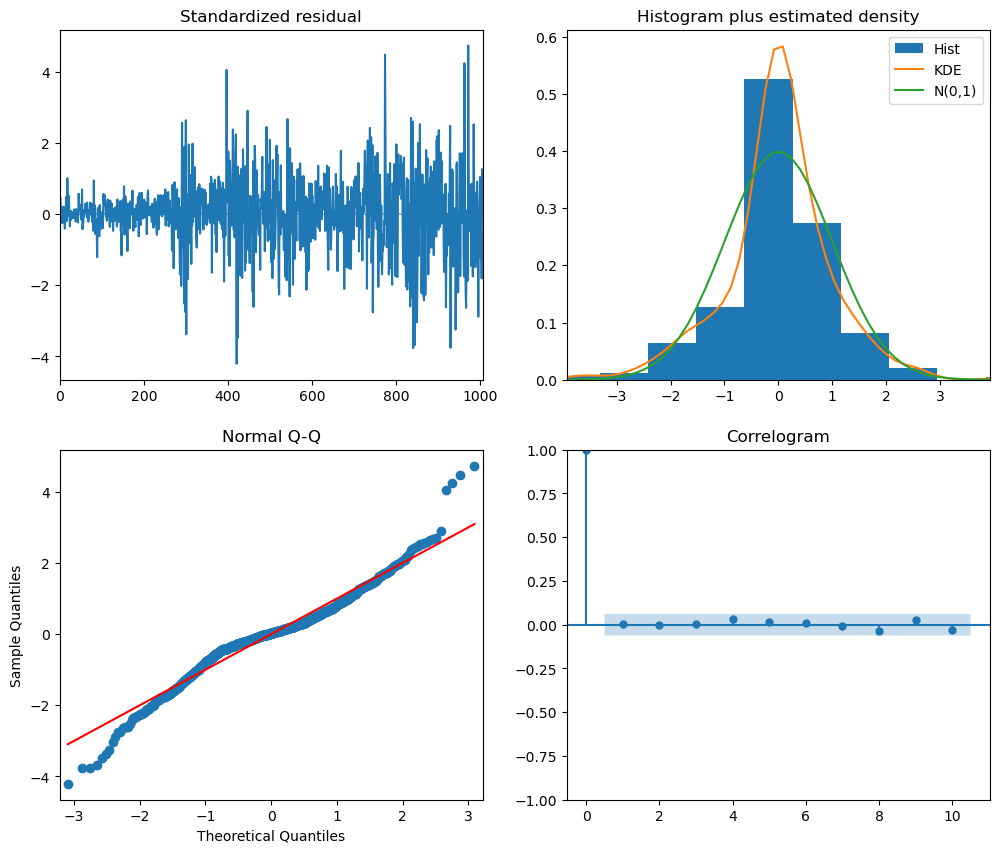

Best (p, d, q): 4 1 1


In [19]:
Models.auto_arima_model(data['Close'])

we got best value for p, d and q as 4, 1, 1 respectively

## ARIMA Model

ARIMA (AutoRegressive Integrated Moving Average) is a time series forecasting model that combines three key components: autoregression (AR), differencing (I), and moving average (MA).

The autoregressive component (AR) captures the linear relationship between the current observation and a specified number of lagged observations from the past. It uses a regression model to predict the current value based on its own past values.

The differencing component (I) is used to transform a non-stationary time series into a stationary one. Stationarity refers to the statistical properties of the time series remaining constant over time. Differencing involves taking the difference between consecutive observations to remove trends or seasonality.

The moving average component (MA) considers the relationship between the current observation and the residual errors from a moving average model applied to lagged values. It helps capture the short-term fluctuations or random shocks in the data.

The ARIMA model combines these three components to forecast future values of a time series. It is characterized by three parameters: p, d, and q. The parameter p represents the order of the autoregressive component, d represents the order of differencing, and q represents the order of the moving average component.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  754
Model:                 ARIMA(4, 1, 1)   Log Likelihood               -1382.412
Date:                Mon, 29 May 2023   AIC                           2776.823
Time:                        11:09:08   BIC                           2804.568
Sample:                             0   HQIC                          2787.512
                                - 754                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5569      0.028     19.712      0.000       0.502       0.612
ar.L2         -0.0254      0.026     -0.971      0.332      -0.077       0.026
ar.L3         -0.1889      0.033     -5.798      0.0

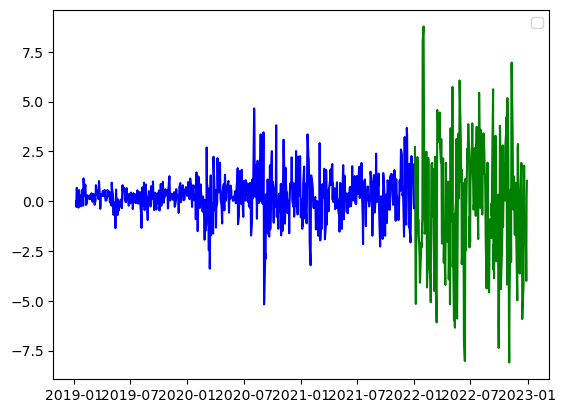

In [20]:
train_df = pd.DataFrame(rolling_mean_diff[(rolling_mean_diff.index.year == 2019) | (rolling_mean_diff.index.year == 2020) | (rolling_mean_diff.index.year == 2021)])
test_df = pd.DataFrame(rolling_mean_diff[(rolling_mean_diff.index.year == 2022)])

arima_model_fit = Models.arima_model(train_df, test_df, 4, 1, 1)


In [21]:
arima_forecast = Forecast.predictions(rolling_mean_diff, train_df, test_df, 'Close', arima_model_fit)
arima_forecast.head()

Date
2022-01-03   -0.364592
2022-01-04    0.241820
2022-01-05    0.390477
2022-01-06    0.336092
2022-01-07    0.252821
Name: predicted_mean, dtype: float64

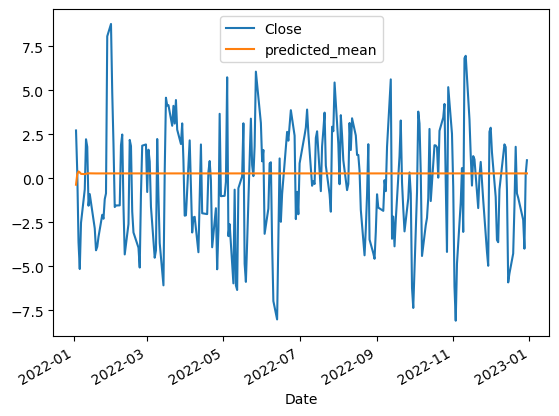

In [22]:
test_df['Close'].plot()
arima_forecast.plot()
plt.legend()

## SARIMAX Model

SARIMAX model is used to capture seasonality and trends in data, while also considering the impact of external factors.
The SARIMAX model builds upon the basic ARIMA framework by adding seasonal components.

In [23]:
train_df = data[(data.index.year == 2019) | (data.index.year == 2020) | (data.index.year == 2021)]
test_df = data[data.index.year == 2022]

sarimax_model_fit = Models.model_sarimax(data['Close'], 4, 1, 1, 7)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.44163D+00    |proj g|=  1.08888D-01

At iterate    5    f=  2.38828D+00    |proj g|=  1.24436D-02

At iterate   10    f=  2.34813D+00    |proj g|=  3.99305D-02

At iterate   15    f=  2.31575D+00    |proj g|=  2.67668D-02

At iterate   20    f=  2.30861D+00    |proj g|=  5.87521D-03

At iterate   25    f=  2.30818D+00    |proj g|=  2.23751D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     29     36      1     0     0   

In [24]:
sarimax_forecast = Forecast.predictions(data, train_data, test_data, 'Close', sarimax_model_fit)
sarimax_forecast.head()

Date
2022-01-03    177.572127
2022-01-04    181.958901
2022-01-05    180.049705
2022-01-06    175.191071
2022-01-07    172.668259
Name: predicted_mean, dtype: float64

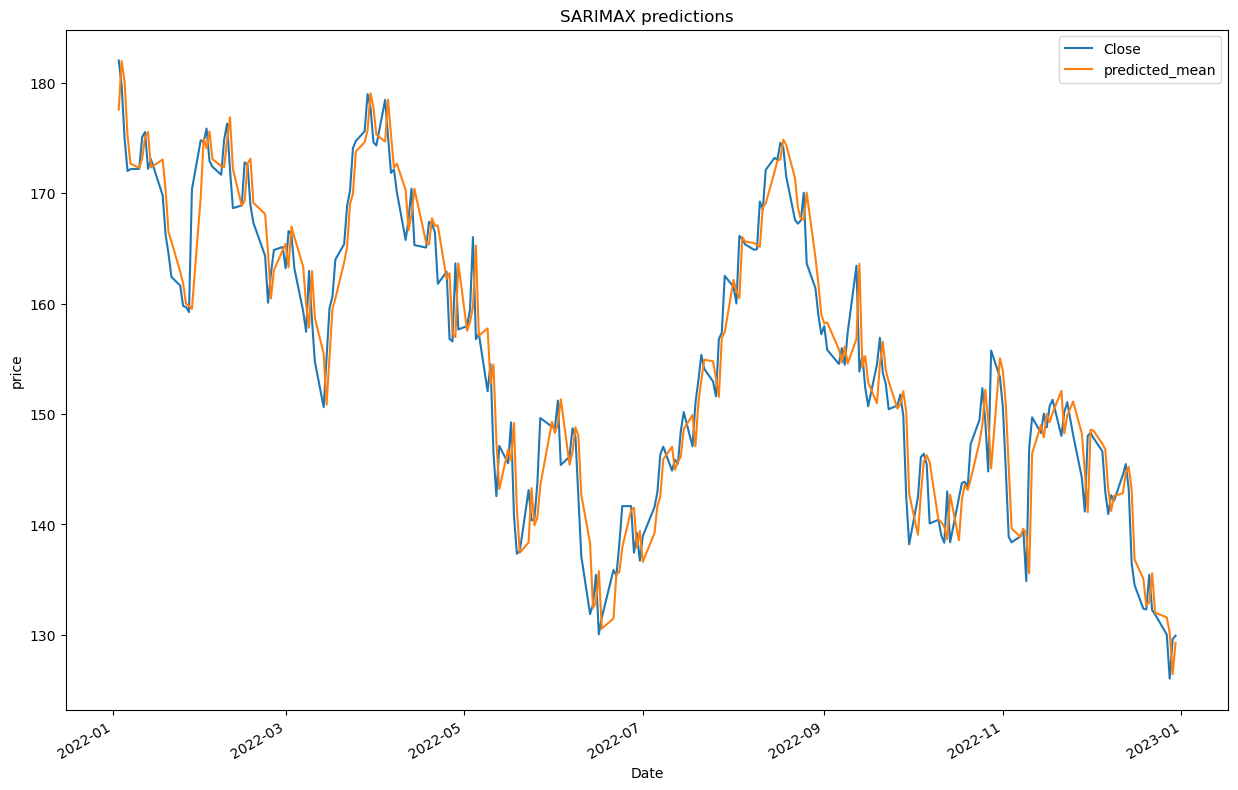

In [25]:
plt.figure(figsize=(15,10))
test_data['Close'].plot()
sarimax_forecast.plot()
plt.xlabel('Date')
plt.ylabel('price')
plt.title('SARIMAX predictions')
plt.legend()
plt.show()

## Facebook Prophet

In [103]:
# !pip install pystan
# !conda install -c conda-forge fbprophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.0/36.0 MB 22.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.5/195.5 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 6.2 MB/s eta 0:00:00
Retrieving notices: ...working... done
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: - 
Found conflicts! Looking for incompatible packages.
This can take several minutes.  Press CTRL-C to abort.
                                                                               failed

UnsatisfiableError: The following specifications were found
to be incompatible with the existing python installation in your environm

In [26]:
def make_prophet_dataset(df, col1, col2):
    df_prophet = df.copy(deep = True)
    df_prophet.reset_index(inplace = True)
    df_prophet = df_prophet[[col1, col2]]
    col_names = {col1:'ds', col2: 'y'}
    df_prophet.rename(columns = col_names, inplace = True)
    print(df_prophet.head())
    return df_prophet

In [27]:
df_prophet = make_prophet_dataset(data, 'Date', 'Close')

          ds          y
0 2019-01-02  39.480000
1 2019-01-03  35.547501
2 2019-01-04  37.064999
3 2019-01-07  36.982498
4 2019-01-08  37.687500


In [28]:
df_prophet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1008 non-null   datetime64[ns]
 1   y       1008 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 15.9 KB


<Axes: xlabel='ds'>

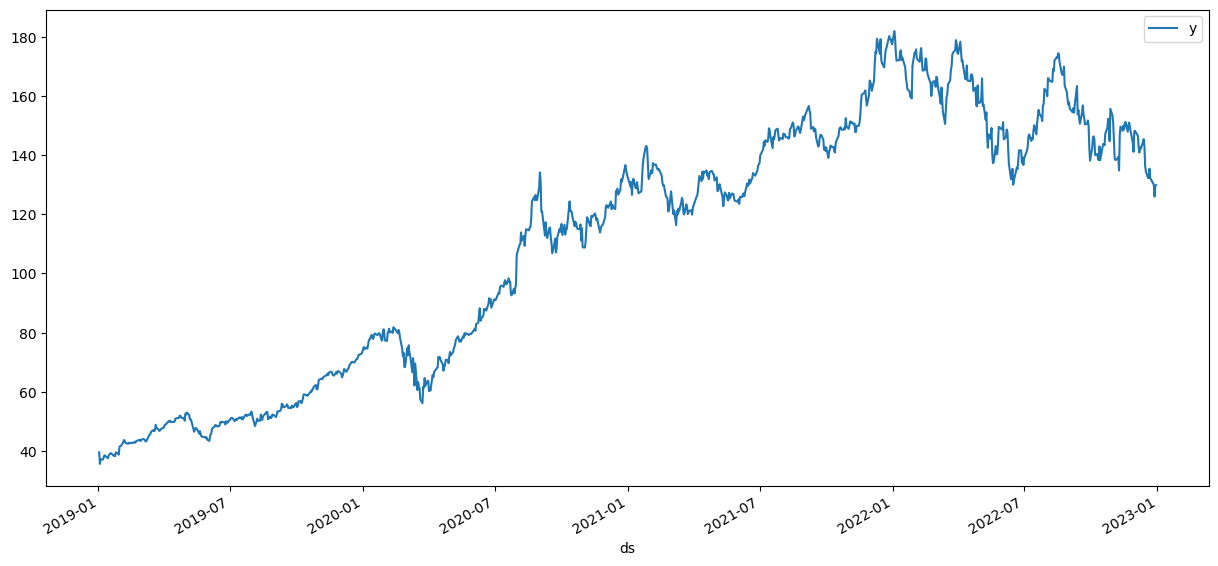

In [29]:
df_prophet.plot(x = 'ds', y = 'y', figsize = (15,7))

In [30]:
train_df = df_prophet[(df_prophet['ds'].dt.year == 2019) | (df_prophet['ds'].dt.year == 2020) | (df_prophet['ds'].dt.year == 2021)]
test_df = df_prophet[(df_prophet['ds'].dt.year == 2022)]

model_prophet, forecast = Models.prophet_model(train_df, test_df, 356)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


          ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper   
0 2022-01-03  168.777523  171.377216  180.438949   168.777523   168.777523  \
1 2022-01-04  168.920185  171.754305  180.527001   168.920185   168.920185   
2 2022-01-05  169.062846  172.079911  181.017225   169.062846   169.062846   
3 2022-01-06  169.205508  171.879136  180.811756   169.205508   169.205508   
4 2022-01-07  169.348169  171.943405  181.105521   169.348169   169.348169   

   additive_terms  additive_terms_lower  additive_terms_upper    weekly   
0        7.229436              7.229436              7.229436 -2.585974  \
1        7.337807              7.337807              7.337807 -2.427992   
2        7.472510              7.472510              7.472510 -2.238171   
3        7.252558              7.252558              7.252558 -2.401781   
4        7.070672              7.070672              7.070672 -2.530281   

   weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper   
0     -2.

In [31]:
forecast[['ds','yhat','yhat_upper','yhat_lower']].head()

ds        yhat  yhat_upper  yhat_lower
0 2022-01-03  176.006959  180.438949  171.377216
1 2022-01-04  176.257991  180.527001  171.754305
2 2022-01-05  176.535356  181.017225  172.079911
3 2022-01-06  176.458066  180.811756  171.879136
4 2022-01-07  176.418841  181.105521  171.943405

In [42]:
# !pip install plotly

In [32]:
plot_plotly(model_prophet, forecast)

The blue line in the graph represents the predicted values while the black dots represents the data in our dataset

In [33]:
plot_components_plotly(model_prophet, forecast)

Cross Validation

Next measure the forecast error using historical data. we can do this by comparing predicted values by the actual values. In order to perform this operation select cut of points in the history of the data and fit the model with data upti cutoff point. Afterwards, compare the actual values to the predicted values. The cross_validation method allow us to do this in Prophet. This mehtod takes the following parameter as explained below:
    
    horizon : the forecast horizon
    initial : the state of initial training period
    period :  the space between cutoff dates
   

In [34]:
df_cv = cross_validation(model_prophet, horizon = '251 days', period = '30 days', initial = '757 days')

INFO:prophet:Making 3 forecasts with cutoffs between 2021-02-23 00:00:00 and 2021-04-24 00:00:00
  0%|                                                                                                               | 0/3 [00:00<?, ?it/s]INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
 33%|██████████████████████████████████▎                                                                    | 1/3 [00:00<00:00,  4.53it/s]INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
 67%|████████████████████████████████████████████████████████████████████▋                                  | 2/3 [00:00<00:00,  4.35it/s]INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.02it/s]


In [35]:
df_cv.head()

ds        yhat  yhat_lower  yhat_upper           y     cutoff
0 2021-02-24  129.449762  125.634173  133.469156  125.349998 2021-02-23
1 2021-02-25  128.896199  125.112878  132.723688  120.989998 2021-02-23
2 2021-02-26  128.352808  124.617025  131.902374  121.260002 2021-02-23
3 2021-03-01  127.382673  123.535858  131.163953  127.790001 2021-02-23
4 2021-03-02  127.119181  123.392399  130.639276  125.120003 2021-02-23

Obtaining the performance metrics

we use performance_metrics utility to compite Mean Squared Error(MSE), Root Mean Squared Error(RMSE), Mean Absolute Error(MAE), Mean Absolute Percentage Error(MAPE) and the coverage of the yhat_lower and yhat_upper estimates(difference)

In [36]:
df_performance = performance_metrics(df_cv)
df_performance.head()

horizon        mse      rmse       mae      mape     mdape     smape   
0 25 days  42.371128  6.509311  5.297460  0.041622  0.035911  0.041933  \
1 26 days  44.891077  6.700080  5.494188  0.043069  0.038407  0.043442   
2 27 days  46.465895  6.816590  5.591554  0.043728  0.038407  0.044198   
3 28 days  47.787010  6.912815  5.688645  0.044429  0.039663  0.044969   
4 29 days  50.636668  7.115945  5.888930  0.045913  0.040828  0.046535   

   coverage  
0  0.442308  
1  0.423077  
2  0.413462  
3  0.403846  
4  0.384615

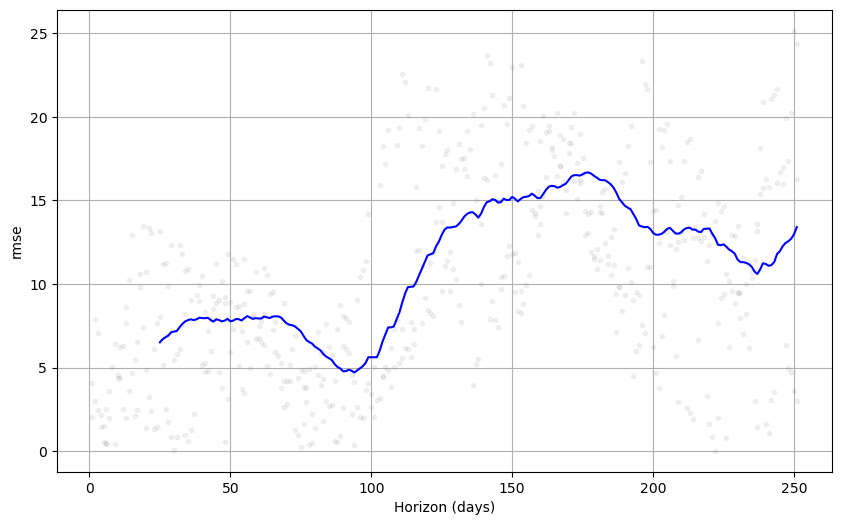

In [37]:
fig = plot_cross_validation_metric(df_cv, metric = 'rmse')

## LSTM Model

In [38]:
scaler = MinMaxScaler()

In [39]:
train_data = data[(data.index.year == 2019) | (data.index.year == 2020) | (data.index.year == 2021)]

test_data = data[data.index.year == 2022]

print('length of training data: ', len(train_data))
print('length of testing data: ', len(test_data))

length of training data:  757
length of testing data:  251


In [40]:
scaler ,scaled_train, scaled_test = Features.preprocessing(train_data['Close'], test_data['Close'], scaler)

In [41]:
n_input = 12
n_features = 1

model = Models.lstm_model(n_input, n_features)

2023-05-29 11:10:12.740500: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [42]:
generator_train = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size = 1)
generator_test = TimeseriesGenerator(scaled_test, scaled_test, length = n_input, batch_size = 1)

In [43]:
model.fit(generator_train, epochs = 50)

Epoch 1/50
745/745 [==============================] - 3s 3ms/step - loss: 0.0407
Epoch 2/50
745/745 [==============================] - 2s 3ms/step - loss: 0.0236
Epoch 3/50
745/745 [==============================] - 2s 3ms/step - loss: 0.0205
Epoch 4/50
745/745 [==============================] - 2s 3ms/step - loss: 0.0220
Epoch 5/50
745/745 [==============================] - 2s 3ms/step - loss: 0.0173
Epoch 6/50
745/745 [==============================] - 2s 3ms/step - loss: 0.0168
Epoch 7/50
745/745 [==============================] - 2s 3ms/step - loss: 0.0167
Epoch 8/50
745/745 [==============================] - 2s 3ms/step - loss: 0.0152
Epoch 9/50
745/745 [==============================] - 2s 3ms/step - loss: 0.0157
Epoch 10/50
745/745 [==============================] - 2s 3ms/step - loss: 0.0139
Epoch 11/50
745/745 [==============================] - 2s 3ms/step - loss: 0.0141
Epoch 12/50
745/745 [==============================] - 2s 3ms/step - loss: 0.0152
Epoch 13/50
745/745 [====

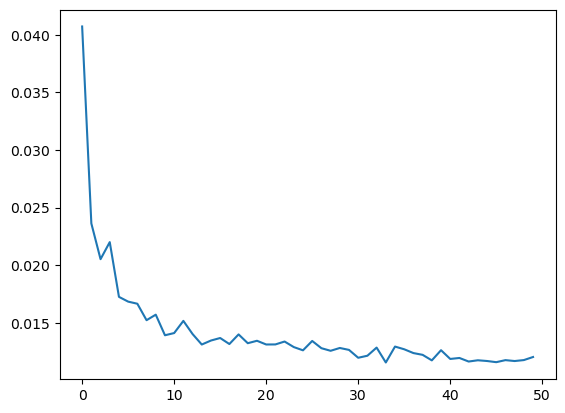

In [44]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)
plt.show()

In [45]:
# get first prediciton

last_train_batch = scaled_train[-12:]
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

print('Predicted value of first value in test data : ', model.predict(last_train_batch))
print('Actual value of first value in test data: ', scaled_test[0])

1/1 [==============================] - 0s 163ms/step
Predicted value of first value in test data :  [[0.9638986]]
Actual value of first value in test data:  [1.01160356]


In [46]:
lstm_preds = model.predict(generator_test)

239/239 [==============================] - 0s 847us/step


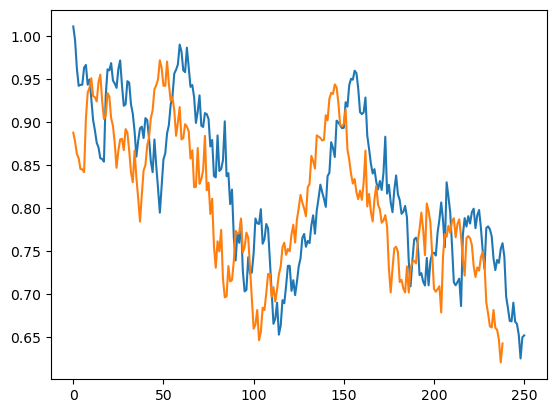

In [48]:
plt.plot(scaled_test,label = "original")
plt.plot(lstm_preds,label = "predicted")
plt.show()

    From ARIMA, SARIMAX, Prophet and LSTM, we can conclude that prophet performs well when compared to other 3 models. SO, we can choose prophet to implement Bolloinger bands

## Bollinger Bands

In [308]:
# predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

In [49]:
forecast.set_index('ds', inplace = True)

In [50]:
Forecast.bollinger_bands(forecast, 'yhat', 30)

trend  yhat_lower  yhat_upper  trend_lower  trend_upper   
ds                                                                         
2022-01-03  168.777523  171.377216  180.438949   168.777523   168.777523  \
2022-01-04  168.920185  171.754305  180.527001   168.920185   168.920185   
2022-01-05  169.062846  172.079911  181.017225   169.062846   169.062846   
2022-01-06  169.205508  171.879136  180.811756   169.205508   169.205508   
2022-01-07  169.348169  171.943405  181.105521   169.348169   169.348169   
...                ...         ...         ...          ...          ...   
2022-12-23  219.279728  172.319311  268.966577   166.973800   262.078150   
2022-12-27  219.850374  173.173045  270.224256   167.309328   262.762746   
2022-12-28  219.993036  172.136091  270.668963   167.121841   263.270425   
2022-12-29  220.135697  172.851534  272.440358   166.832681   263.816204   
2022-12-30  220.278359  172.719028  271.007587   166.543522   264.064999   

            additive_terms  additive_terms_lower  additive_terms_upper   
ds                                                                       
2022-01-03        7.229436              7.229436              7.229436  \
2022-01-04        7.337807              7.337807              7.337807   
2022-01-05        7.472510              7.472510              7.472510   
2022-01-06        7.252558              7.252558              7.252558   
2022-01-07        7.070672              7.070672              7.070672   
...                    ...                   ...                   ...   
2022-12-23        6.372642              6.372642              6.372642   
2022-12-27        7.216994              7.216994              7.216994   
2022-12-28        7.510908              7.510908              7.510908   
2022-12-29        7.420934              7.420934              7.420934   
2022-12-30        7.337745              7.337745              7.337745   

              weekly  weekly_lower  weekly_upper    yearly  yearly_lower   
ds                                                                         
2022-01-03 -2.585974     -2.585974     -2.585974  9.815410      9.815410  \
2022-01-04 -2.427992     -2.427992     -2.427992  9.765799      9.765799   
2022-01-05 -2.238171     -2.238171     -2.238171  9.710680      9.710680   
2022-01-06 -2.401781     -2.401781     -2.401781  9.654339      9.654339   
2022-01-07 -2.530281     -2.530281     -2.530281  9.600952      9.600952   
...              ...           ...           ...       ...           ...   
2022-12-23 -2.530281     -2.530281     -2.530281  8.902923      8.902923   
2022-12-27 -2.427992     -2.427992     -2.427992  9.644987      9.644987   
2022-12-28 -2.238171     -2.238171     -2.238171  9.749079      9.749079   
2022-12-29 -2.401781     -2.401781     -2.401781  9.822715      9.822715   
2022-12-30 -2.530281     -2.530281     -2.530281  9.868025      9.868025   

            yearly_upper  multiplicative_terms  multiplicative_terms_lower   
ds                                                                           
2022-01-03      9.815410                   0.0                         0.0  \
2022-01-04      9.765799                   0.0                         0.0   
2022-01-05      9.710680                   0.0                         0.0   
2022-01-06      9.654339                   0.0                         0.0   
2022-01-07      9.600952                   0.0                         0.0   
...                  ...                   ...                         ...   
2022-12-23      8.902923                   0.0                         0.0   
2022-12-27      9.644987                   0.0                         0.0   
2022-12-28      9.749079                   0.0                         0.0   
2022-12-29      9.822715                   0.0                         0.0   
2022-12-30      9.868025                   0.0                         0.0   

            multiplicative_terms_upper        yhat   UpperBan

In [51]:
buy_price, sell_price = Forecast.bb_strategy(forecast, 'yhat')

In [52]:
forecast['Buy'] = buy_price
forecast['Sell'] = sell_price

In [53]:
forecast

trend  yhat_lower  yhat_upper  trend_lower  trend_upper   
ds                                                                         
2022-01-03  168.777523  171.377216  180.438949   168.777523   168.777523  \
2022-01-04  168.920185  171.754305  180.527001   168.920185   168.920185   
2022-01-05  169.062846  172.079911  181.017225   169.062846   169.062846   
2022-01-06  169.205508  171.879136  180.811756   169.205508   169.205508   
2022-01-07  169.348169  171.943405  181.105521   169.348169   169.348169   
...                ...         ...         ...          ...          ...   
2022-12-23  219.279728  172.319311  268.966577   166.973800   262.078150   
2022-12-27  219.850374  173.173045  270.224256   167.309328   262.762746   
2022-12-28  219.993036  172.136091  270.668963   167.121841   263.270425   
2022-12-29  220.135697  172.851534  272.440358   166.832681   263.816204   
2022-12-30  220.278359  172.719028  271.007587   166.543522   264.064999   

            additive_terms  additive_terms_lower  additive_terms_upper   
ds                                                                       
2022-01-03        7.229436              7.229436              7.229436  \
2022-01-04        7.337807              7.337807              7.337807   
2022-01-05        7.472510              7.472510              7.472510   
2022-01-06        7.252558              7.252558              7.252558   
2022-01-07        7.070672              7.070672              7.070672   
...                    ...                   ...                   ...   
2022-12-23        6.372642              6.372642              6.372642   
2022-12-27        7.216994              7.216994              7.216994   
2022-12-28        7.510908              7.510908              7.510908   
2022-12-29        7.420934              7.420934              7.420934   
2022-12-30        7.337745              7.337745              7.337745   

              weekly  weekly_lower  ...  yearly_lower  yearly_upper   
ds                                  ...                               
2022-01-03 -2.585974     -2.585974  ...      9.815410      9.815410  \
2022-01-04 -2.427992     -2.427992  ...      9.765799      9.765799   
2022-01-05 -2.238171     -2.238171  ...      9.710680      9.710680   
2022-01-06 -2.401781     -2.401781  ...      9.654339      9.654339   
2022-01-07 -2.530281     -2.530281  ...      9.600952      9.600952   
...              ...           ...  ...           ...           ...   
2022-12-23 -2.530281     -2.530281  ...      8.902923      8.902923   
2022-12-27 -2.427992     -2.427992  ...      9.644987      9.644987   
2022-12-28 -2.238171     -2.238171  ...      9.749079      9.749079   
2022-12-29 -2.401781     -2.401781  ...      9.822715      9.822715   
2022-12-30 -2.530281     -2.530281  ...      9.868025      9.868025   

            multiplicative_terms  multiplicative_terms_lower   
ds                                                             
2022-01-03                   0.0                         0.0  \
2022-01-04                   0.0                         0.0   
2022-01-05                   0.0                         0.0   
2022-01-06                   0.0                         0.0   
2022-01-07                   0.0                         0.0   
...                          ...                         ...   
2022-12-23                   0.0                         0.0   
2022-12-27                   0.0                         0.0   
2022-12-28                   0.0                         0.0   
2022-12-29                   0.0                         0.0   
2022-12-30                   0.0                         0.0   

            multiplicative_terms_upper        yhat   UpperBand   LowerBand   
ds                                                                           
2022-01-03                         0.0  176.006959         NaN         NaN  \
2022-01-04                         0.0  176.257991         NaN         NaN

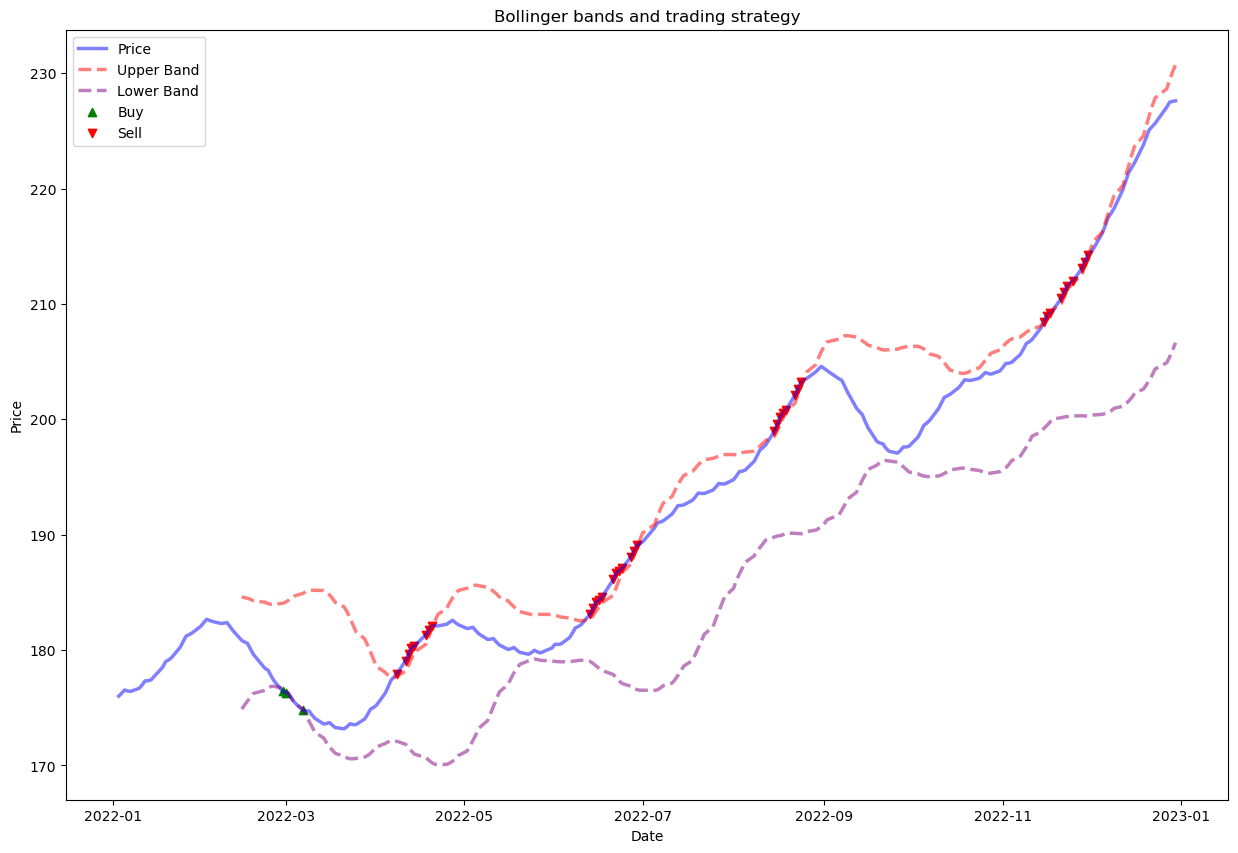

In [54]:
Visualizations.bollinger_bands_visualization(forecast, 'yhat', 'UpperBand', 'LowerBand', 'Buy', 'Sell')

As the price is increasing, windows to sell the stock will be maximum however buying stock will be minimum. 